In [2]:
using CairoMakie, Dierckx, Optim, LinearAlgebra, QuantEcon

In [3]:
set_theme!(theme_dark())

In [75]:
function create_EGM_model(;nk = 101, nz = 19)

    p = (;α = 0.33, # Capital share
    β = 0.96, # Discount factor
    A = 0.5, # TFP
    γ = 2.0, # Risk aversion
    δ = 0.1, # Depreciation rate
    nk = nk, # Number of capital gridpoints
    nz = nz, # Number of shock gridpoints
    θ = 2, # Grid expansion parameter
    lb = 10^-4, # Lower bound of capital grid
    ub = 500.0, # Upper bound of capital grid
    ρ = 0.98, # Persistence of AR(1) process
    μ = 0.5, # Mean of AR(1) process
    σ = 0.01, # Var of AR(1) process
    toler = 1e-6, # Tolerance
    maxiter = 500, # Maximum number of iterations
    print_skip_pol = 5, # Print every x iterations in policy step
    print_skip_val = 50, # Print every x iterations in value step
    kgrid = LinRange(0.0,1.0,nk), # Capital grid
    zgrid = LinRange(0.0,1.0,nz), # Shock grid
    Π = zeros(Float64, nz, nz)) # Transition matrix

    # Create productivity grid and transition matrix
    mc = rouwenhorst(p.nz, p.μ, p.ρ, p.σ)
    zgrid, Π = exp.(mc.state_values), mc.p

    # Create capital grid
    temp_grid = LinRange(0.0,1.0,p.nk)
    kgrid = p.lb .+ (p.ub - p.lb) * (temp_grid .^ p.θ)

    # Return NamedTuple
    p = (p..., kgrid = kgrid, zgrid = zgrid, Π = Π)

    return p
end

model_EGM = create_EGM_model(nk = 101, nz = 19)

(α = 0.33, β = 0.96, A = 0.5, γ = 2.0, δ = 0.1, nk = 101, nz = 19, θ = 2, lb = 0.0001, ub = 500.0, ρ = 0.98, μ = 0.5, σ = 0.01, toler = 1.0e-6, maxiter = 500, print_skip_pol = 5, print_skip_val = 50, kgrid = [0.0001, 0.05009999000000001, 0.20009996000000002, 0.45009991, 0.8000998400000001, 1.2500997500000004, 1.80009964, 2.4500995100000007, 3.2000993600000007, 4.05009919  …  414.05001719, 423.20001536, 432.4500135100001, 441.80001164, 451.25000975, 460.80000784, 470.45000590999996, 480.20000395999995, 490.05000199, 500.0], zgrid = [0.008387608038651633, 0.014299146011397482, 0.024377101995354325, 0.041557943475662926, 0.07084774335585627, 0.12078082597029194, 0.20590645842864538, 0.35102814773808405, 0.5984307701894207, 1.0202013400267553, 1.7392333851131028, 2.9650350859298533, 5.054774785284692, 8.617351022656463, 14.690810531036542, 25.044809418971962, 42.696247256574644, 72.78831710388745, 124.0891049505581], Π = [0.005637710113660432 0.033826260681962594 … 7.8580342233181e-10 1.45

In [76]:
function utility(c)
    if model_EGM.γ == 1.0
        return log(c)
    else
        return (c^(1-model_EGM.γ)-1) / (1-model_EGM.γ)
    end
end 

function marginal_utility(c)
    return c^(-model_EGM.γ)
end

function inverse_marginal_utility(u)
    return u^(-1/model_EGM.γ)
end

function resources(i ,j , p)
    (; α, δ, A, kgrid, zgrid) = p
    return (A * zgrid[j] * (kgrid[i] ^ α)) + (1.0 - δ) * kgrid[i]
end

function marginal_prod(i ,j , p)
    (; α, δ, A, kgrid, zgrid) = p
    return α * A * zgrid[j] * (kgrid[i] ^ (α - 1)) + (1.0 - δ)
end

function initial_guess(p)
    (; nk, nz) = p
    c_pol = zeros(nk, nz)
    for i in 1:nk
        for j in 1:nz
            c_pol[i,j] = 1/2 * resources(i, j, p)
        end
    end
    return c_pol
end

function resource_grid(p)
    (; nk, nz) = p
    Ygrid = zeros(nk, nz)
    for i in 1:nk
        for j in 1:nz
            Ygrid[i,j] = resources(i, j, p)
        end
    end
    return Ygrid
end

function marginal_prod_grid(p)
    (; nk, nz) = p
    MPgrid = zeros(nk, nz)
    for i in 1:nk
        for j in 1:nz
            MPgrid[i,j] = marginal_prod(i, j, p)
        end
    end
    return MPgrid
end

function vals(consumption, p)
    (; nk, nz, β, toler, maxiter, Π, print_skip_val, γ) = p
    v1 = zeros(nk,nz)
    v2 = zeros(nk,nz)
    iter = 0
    error = toler + 1
    if iter == 0
        println("/// Finding Value Functions... ///")
    end
    while error >= toler && iter <= maxiter
        v2 = (1-β) * utility.(consumption) + (β * v1 * Π')
        error = maximum(abs.(v2 - v1)/(1 .+ abs.(v1)))
        v1 = copy(v2)
        if iter % print_skip_val == 0
            println("------------------------------------")
            println("Error at iteration $iter is $error")
        end
        iter += 1
    end
    println("------------------------------------")
    println("/// Found Value Functions ///")
    println("------------------------------------")
    return v1
end

vals (generic function with 1 method)

In [77]:
function egm(p)
    # Unpack parameters
    (; print_skip_pol, toler, maxiter, Π, kgrid, zgrid, nk, nz, β, A, α, δ, lb, ub, γ) = p

    # Initialise matrices
    c_pol_1 = initial_guess(p)
    c_pol_2 = zeros(nk, nz)
    s_pol = zeros(nk, nz)
    g = zeros(nk, nz)
    V1 = zeros(nk, nz)
    V2 = zeros(nk, nz)
    V3 = zeros(nk, nz)
    V4 = zeros(nk, nz)
    v_out = zeros(nk, nz)
    MPgrid = marginal_prod_grid(p)
    Ygrid = resource_grid(p)

    # Create Spline dictionary
    splines = Dict{Int, Spline1D}()

    # Set error and iteration counter
    error = toler + 1
    iter = 0
    if iter == 0
        println("/// Finding Policy Functions... ///")
    end

    while error >= toler && iter <= maxiter
        MUgrid = marginal_utility.(c_pol_1)
        V1 = (β .* MUgrid .* MPgrid)
        V2 = (Π * V1')'
        V3 = inverse_marginal_utility.(V2)
        V4 = kgrid .+ V3
        for j in 1:nz
            g[:,j] = (V4[:,j]./(A*zgrid[j])).^(1/α)
            splines[j] = Spline1D(g[:,j], kgrid, k = 1, bc="extrapolate")
            s_pol[:,j] = splines[j].(kgrid)
        end
        c_pol_2 = Ygrid .- s_pol
        error = maximum(abs.(c_pol_2 - c_pol_1)/(1 .+ abs.(c_pol_1)))
        c_pol_1 = copy(c_pol_2)
        if iter % print_skip_pol == 0
            println("------------------------------------")
            println("Error at iteration $iter is $error")
        end
        iter += 1
    end
    if iter == maxiter
        println("------------------------------------")
        println("Failed to converge after $maxiter iterations")
    else
        println("------------------------------------")
        println("/// Found policy functions ///")
        println("------------------------------------")
    end

    v_out = vals(c_pol_2, p)

    return v_out, s_pol, c_pol_1
end

@time begin 
    v_out, k_pol, c_pol = egm(model_EGM)
end

/// Finding Policy Functions... ///
------------------------------------
Error at iteration 0 is 0.15134679878695034
------------------------------------
Error at iteration 5 is 0.03576711602754599
------------------------------------
Error at iteration 10 is 1.9217353803699033e-6
------------------------------------
/// Found policy functions ///
------------------------------------
/// Finding Value Functions... ///
------------------------------------
Error at iteration 0 is 0.2591245771754239
------------------------------------
Error at iteration 50 is 0.03620244543819116
------------------------------------
Error at iteration 100 is 0.004433387663460335
------------------------------------
Error at iteration 150 is 0.0005717925982219763
------------------------------------
Error at iteration 200 is 7.356248706274066e-5
------------------------------------
Error at iteration 250 is 1.001379404018263e-5
------------------------------------
/// Found Value Functions ///
------------

([-317.3020990273784 -220.04867431470728 … -66.67437098012799 -66.23427668150472; -6.252018387876962 -6.1546005576513885 … -4.3251940020577475 -4.290609808654006; … ; 0.9977441865937602 0.9977442994574333 … 0.9977742743324364 0.9977859201824681; 0.9977887382011533 0.9977888473179375 … 0.997817907784894 0.9978292498926297], [9.999182219005765e-5 9.998921923684262e-5 … 0.476526790810894 0.8552903273576364; 0.00010010517872560454 0.00010051221980089964 … 5.470963370978209 9.556644397389416; … ; 0.0012109992270850024 0.005225917747559446 … 137.04625039363418 234.52524572251974; 0.0012335571776588311 0.005329994859806787 … 137.97795914638968 236.13214268139848], [0.00019073625830523912 0.0003322108595416605 … 1.265497155961262 2.1144386605783225; 0.04655143099544165 0.04765159202463251 … 8.125337499876235 13.59047207235706; … ; 441.07617904021896 441.0949911731865 … 585.0664988965643 685.6824377371058; 450.03137024376946 450.05025277774007 … 594.9603697783598 696.219495458119])

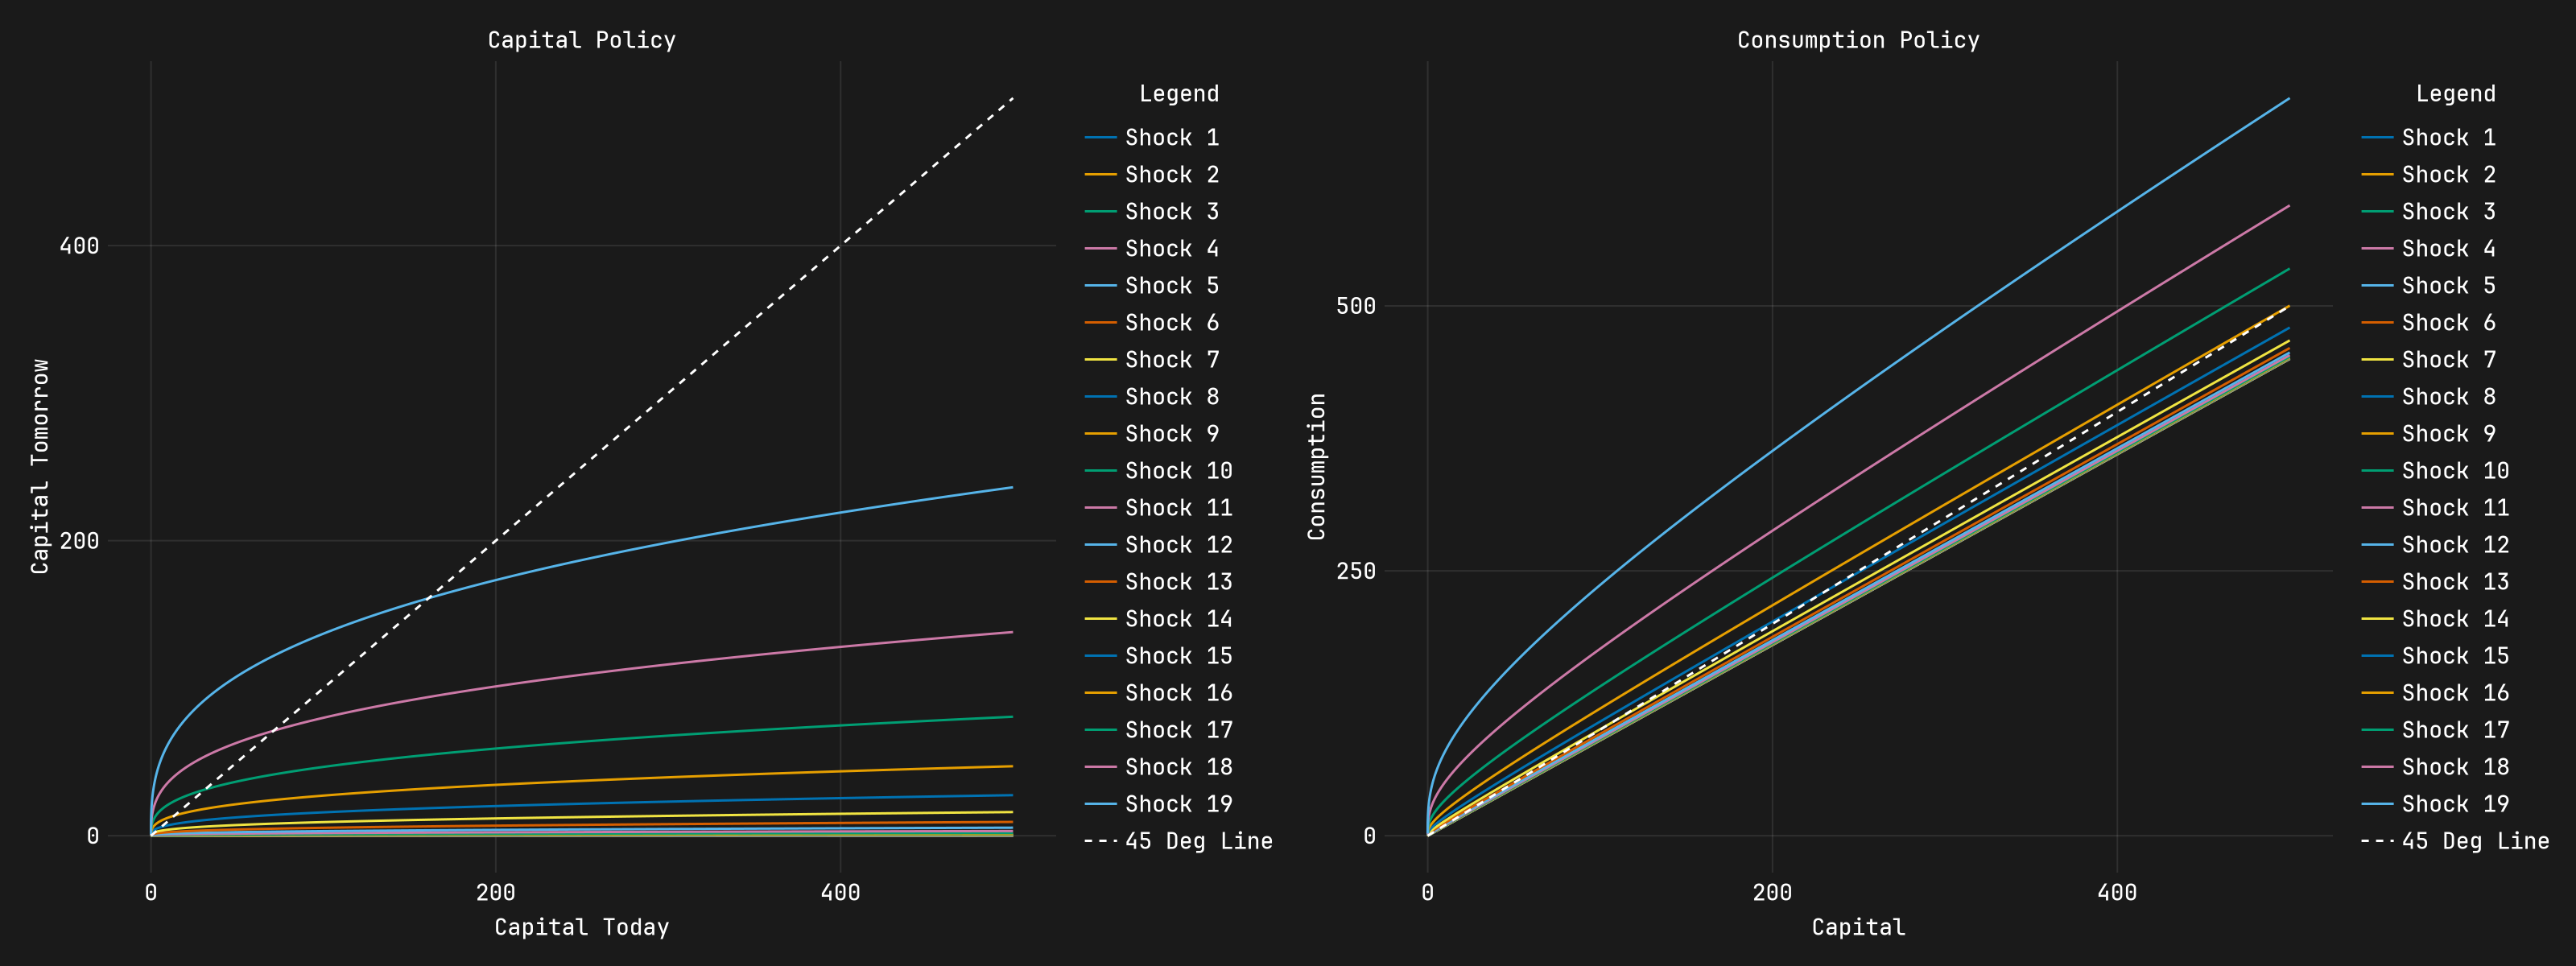

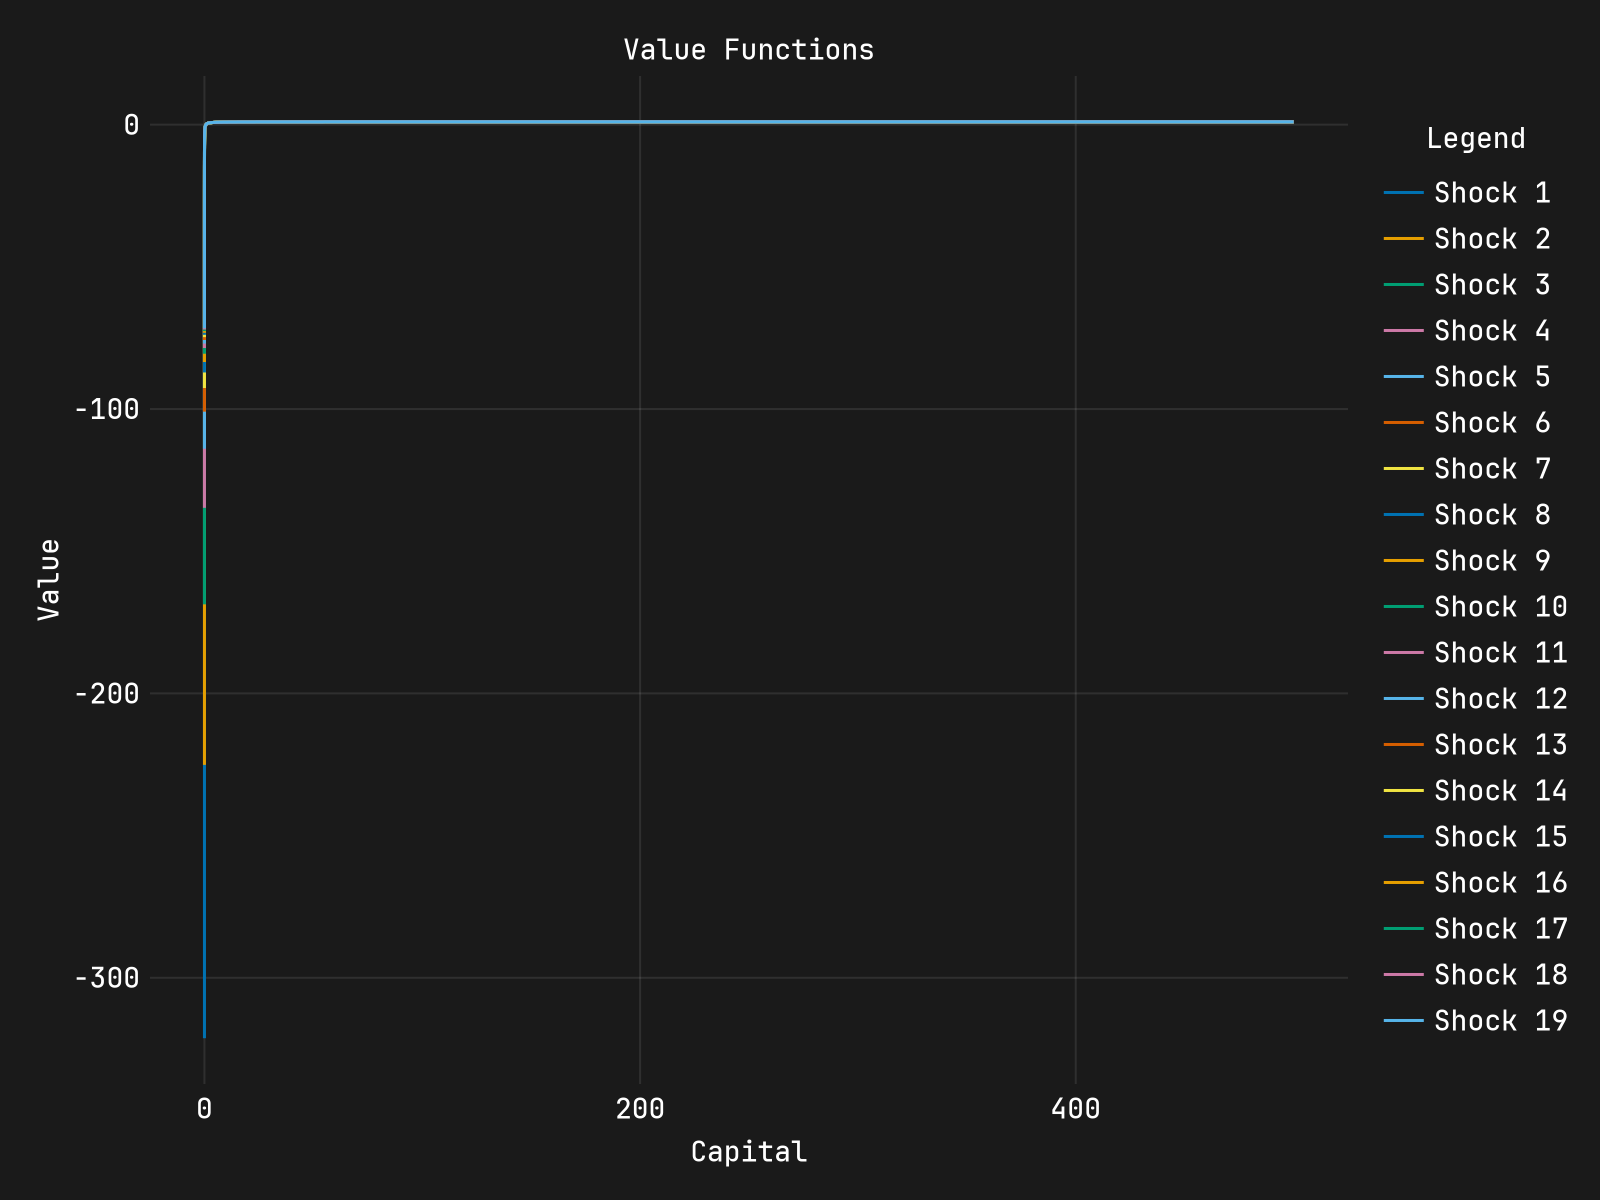

In [69]:
fig1 = Figure(size = (1600, 600))
ax1 = Axis(fig1[1, 1], 
        title = "Capital Policy",
        titlecolor = :white,
        titlefont = "JetBrains Mono",
        xlabel = "Capital Today",
        xlabelfont = "JetBrains Mono",
        xlabelcolor = :white,
        ylabel = "Capital Tomorrow", 
        ylabelfont = "JetBrains Mono",
        ylabelcolor = :white,
        xticklabelcolor = :white, 
        yticklabelcolor = :white,  
        xticklabelfont = "JetBrains Mono", 
        yticklabelfont = "JetBrains Mono")
for j in 1:model_EGM.nz
    lines!(ax1, model_EGM.kgrid, k_pol[:,j], label = "Shock $j")
end
lines!(ax1, model_EGM.kgrid, model_EGM.kgrid, label = "45 Deg Line", color = :white, linestyle = :dash)
legend = Legend(fig1[1,2], ax1, "Legend", orientation = :vertical, fontsize = 4, labelcolor = :white, labelfont = "JetBrains Mono", titlefont = "JetBrains Mono", titlecolor = :white)
ax2 = Axis(fig1[1, 3], 
        title = "Consumption Policy",
        titlecolor = :white,
        titlefont = "JetBrains Mono",
        xlabel = "Capital",
        xlabelfont = "JetBrains Mono",
        xlabelcolor = :white,
        ylabel = "Consumption", 
        ylabelfont = "JetBrains Mono",
        ylabelcolor = :white,
        xticklabelcolor = :white, 
        yticklabelcolor = :white,  
        xticklabelfont = "JetBrains Mono", 
        yticklabelfont = "JetBrains Mono")
for j in 1:model_EGM.nz
    lines!(ax2, model_EGM.kgrid, c_pol[:,j], label = "Shock $j")
end
lines!(ax2, model_EGM.kgrid, model_EGM.kgrid, label = "45 Deg Line", color = :white, linestyle = :dash)
legend = Legend(fig1[1,4], ax2, "Legend", orientation = :vertical, fontsize = 4, labelfont = "JetBrains Mono", labelcolor = :white, titlefont = "JetBrains Mono", titlecolor = :white)
display(fig1)

fig2 = Figure(size = (800, 600))
ax2 = Axis(fig2[1, 1], 
        title = "Value Functions",
        titlecolor = :white,
        titlefont = "JetBrains Mono",
        xlabel = "Capital",
        xlabelfont = "JetBrains Mono",
        xlabelcolor = :white,
        ylabel = "Value", 
        ylabelfont = "JetBrains Mono",
        ylabelcolor = :white,
        xticklabelcolor = :white, 
        yticklabelcolor = :white,  
        xticklabelfont = "JetBrains Mono", 
        yticklabelfont = "JetBrains Mono")
for j in 1:model_EGM.nz
    lines!(ax2, model_EGM.kgrid, v_out[:,j], label = "Shock $j")
end
legend = Legend(fig2[1,2], ax2, "Legend", orientation = :vertical, fontsize = 4, labelfont = "JetBrains Mono", labelcolor = :white, titlefont = "JetBrains Mono", titlecolor = :white)
fig2